In [191]:
# Selecting libraries
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
import re
import cvxopt as opt
from cvxopt import blas, solvers
pd.set_option('display.max_columns', 500)

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, objective_functions
from pypfopt import expected_returns

## What happened here
In this script we tested how we could use forecasted covariance matrices to build portfolios
Issues:
+ we took the square root of the variance, when it should be the square.
+ We took the monthly variance, but the mean value we used in the efficeint frontier was daily returns.
+ I also noted that risk_models.samplecovariance spits out annulaised daily returns always
+ The input volatility data was annulaised daily variance. we get this by multilplying by $ var * \sqrt{252} $
+ we then converted this to monthly by: $ var *(\sqrt{21} / \sqrt{252}) $
+ We had issues whereby the matrix forecasted is not PSD, we fixed this by introducing regulrizastion and zeroing the eigenvalues. 
  I want to find out why this is happening. i would hope regularizing alone would have fixed the issue.

In [192]:
# Define the assets and key initial metrics as investment amount to generate a portfolio

stocks = ['AAPL', 'MSFT', 'NVDA', 'JNJ', 'NVS','JPM','GS','AMZN','DIS','BA','CAT','XOM','CVX','RIO','BHP']
portfolio_value = 10**6                         # Initial Portfolio Value to be allocated in full
weights = [1/len(stocks)]*len(stocks)         # Weight Allocation per asset

benchmark = '^GSPC'                    # Which is your benchmark? ^GSPC is SP500 for Yfinance library

start_date = '2009-01-01'              # Start date for asset data download
live_date = '2015-01-01'               # Portfolio LIVE start date (for analytics)
end_date  ='2015-12-25'

# Warning handling
if len(weights) != len(stocks):
    print(sum((np.array(weights))))
    print('Number of Asset does not match weight allocated')
    
weight = round(sum((np.array(weights))))
if weight != 1.0:
    print(sum((np.array(weights))))
    print('Weight could not be allocated properly, make sure they sum 1.0')


In [193]:
# Download data, clean and isolate values for calculation
# If you use other data source, make sure the format is the same than stock_data.head() on next cell. Check dtypes by stock_data.info()

stock_data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
stock_data = stock_data.dropna()
stock_data = stock_data.reindex(columns=stocks)
stock_prices = stock_data[stocks].values

[*********************100%***********************]  15 of 15 completed


In [194]:
shares_df = pd.DataFrame(index=[stock_data.index[0]])

for s,w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0])

shares_df    

AAPL_shares  MSFT_shares  NVDA_shares  JNJ_shares  NVS_shares  \
2009-01-02      24233.0       4415.0      33369.0      1696.0      2640.0   

            JPM_shares  GS_shares  AMZN_shares  DIS_shares  BA_shares  \
2009-01-02      3047.0      978.0      24527.0      3236.0     1964.0   

            CAT_shares  XOM_shares  CVX_shares  RIO_shares  BHP_shares  
2009-01-02      2133.0      1409.0      1556.0      7397.0      2896.0

In [195]:
# std_data.index = pd.to_datetime(std_data.index)
# std_data = std_data * np.sqrt(21)
# std_data

# vol_data = pd.read_csv('./notebooks/test_vol.csv',index_col=0) #

# # month_vol = vol_data *np.sqrt(21)
# # month_var = month_vol**2
# # std_data = month_var.copy()
# std_data = vol_data.copy()
# std_data.index = pd.to_datetime(std_data.index)
# std_data 
# # convert to monthly volatilty

Each time you move the window forward one step, you should recalculate the volatility forecast for the next period and use it in your covariance matrix for the optimal portfolio weight calculation for that step.

The idea here is that you're trying to predict the optimal portfolio weights for the next period, based on the data you have up to and including the current period. Your GARCH model fits into this by giving you a forecasted volatility for the next period, which you then use in your weight optimization.

In [196]:
# end_date = std_data.index[-1]
# stock_data = stock_data.loc[:end_date]

In [197]:
# window_length = 252 
# df = stock_data.copy()
# start_date = df.index[window_length]
# stock_data = stock_data.loc[start_date:]
# # shares_df = shares_df.loc[start_date:]
# shares_df


MOVING TO MONTHL VARIANCE IS A PROBLEM HERE
1. Check if its causes by the negative returns
2. Try build https://github.com/robertmartin8/PyPortfolioOpt/issues/88

In [198]:
from scipy.optimize import minimize

# Function to calculate portfolio risk
def calculate_portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to calculate risk contributions
def risk_contribution(weights, cov_matrix):
    portfolio_risk = calculate_portfolio_risk(weights, cov_matrix)
    return (weights * np.dot(cov_matrix, weights)) / portfolio_risk

# Objective function to minimize
def risk_parity_objective(weights, args):
    cov_matrix = args[0]
    risk_target = args[1]
    asset_risk = risk_contribution(weights, cov_matrix)
    return np.sum(np.square(asset_risk - risk_target))

# Constraint for the optimization problem
def weight_sum_constraint(x):
    return np.sum(x) - 1.0

# Assuming you have a DataFrame 'stock_data' with historical stock prices
# Replace this with your actual data


# Number of assets and their names
num_assets = len(stock_data.columns)
stocks = stock_data.columns

# Resample the data to get monthly returns
stock_data_monthly = stock_data.resample('M').last()
stock_returns = stock_data_monthly.pct_change().dropna()

# Create a DataFrame to store the optimal portfolio weights over time
optimal_weights_df = pd.DataFrame(index=stock_data_monthly.index, columns=stocks)

# Loop over each end-of-month date to perform Risk Parity optimization
for end_date in stock_data_monthly.index[1:]:  # Skip the first month
    # Extract historical data up to the end_date
    data_window = stock_returns.loc[:end_date]
    
    # Calculate the sample covariance matrix from historical returns
    S = data_window.cov() * 12  # Annualized
    
    # Initial guess for the optimization
    initial_weights = np.repeat(1 / num_assets, num_assets)
    
    # Constraints for the optimization
    constraints = ({'type': 'eq', 'fun': weight_sum_constraint})
    
    # Risk contribution target (equal for all assets)
    risk_target = np.repeat(1 / num_assets, num_assets)
    
    # Arguments for the objective function
    args = [S, risk_target]
    
    # Perform the optimization
    solution = minimize(risk_parity_objective, initial_weights, args=args,
                        constraints=constraints, bounds=[(0, 1) for asset in range(num_assets)])
    
    # Extract the optimal asset weights from the solution
    optimal_weights = solution.x
    
    # Store the optimal weights in the DataFrame
    optimal_weights_df.loc[end_date] = optimal_weights

# Forward-fill the optimal weights for the days when we're not rebalancing
optimal_weights_df = optimal_weights_df.fillna(method='ffill').resample('D').ffill()

# Sort the DataFrame by index
optimal_weights_df.sort_index(inplace=True)


In [199]:
# import numpy as np
# import pandas as pd
# from scipy.optimize import minimize

# # Function to calculate portfolio risk
# def calculate_portfolio_risk(weights, cov_matrix):
#     return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# # Function to calculate risk contributions
# def risk_contribution(weights, cov_matrix):
#     portfolio_risk = calculate_portfolio_risk(weights, cov_matrix)
#     return (weights * np.dot(cov_matrix, weights)) / portfolio_risk

# # Objective function to minimize
# def risk_parity_objective(weights, args):
#     cov_matrix = args[0]
#     risk_target = args[1]
#     asset_risk = risk_contribution(weights, cov_matrix)
#     return np.sum(np.square(asset_risk - risk_target))

# # Constraint for the optimization problem
# def weight_sum_constraint(x):
#     return np.sum(x) - 1.0

# # Assumed that 'df' is your DataFrame with historical prices
# df = stock_data.copy()
# volatility_df = std_data.copy()
# num_assets = len(df.columns)
# stocks = df.columns
# window_length = 31  # months

# vol_data_ind = volatility_df.resample('M').last().index
# volatility_df_month = volatility_df.resample('M').last()

# # Create portfolio weights over time
# optimal_weights_df = pd.DataFrame(index=df.index, columns=stocks)

# # Loop over each end-of-month date
# for end_date in vol_data_ind[window_length:]:
#     # Extract the window of data
#     data_window = df.loc[:end_date].tail(window_length * 20)
#     # Resample the data to get monthly returns
#     data_window_monthly = data_window.resample('M').last()

#     # Calculate the expected returns using the monthly returns
#     mu = expected_returns.mean_historical_return(data_window)

#     # Get the dates that are greater than end_date
#     future_dates = vol_data_ind[vol_data_ind > end_date]

#     # Check if there are any future dates
#     if len(future_dates) > 0:
#         # Get the first future date
#         next_month = future_dates[0]
#     else:
#         # If there are no future dates, break the loop
#         break
    
#     next_month = vol_data_ind[vol_data_ind > end_date][0]
#     # Get the volatility data for the closest week
#     volatility_df_pred = volatility_df_month[volatility_df_month.index == next_month]
#     #convert daily volatility to monthly
#     forecasted_volatility_monthly = volatility_df_pred * (np.sqrt(21)/ np.sqrt(252))
#     S =  risk_models.sample_cov(data_window,frequency=252)*np.sqrt(21)# annualised daily frequency =252
    
#     S_adj =  S.copy()
#     for symbols in stocks:
#         S_adj[symbols][symbols] = forecasted_volatility_monthly[symbols][0]**(1/2) #Volatility = Variance^1/2 = Standard Deviation

#     # Risk Parity Optimization
#     initial_weights = np.repeat(1 / num_assets, num_assets)
#     constraints = ({'type': 'eq', 'fun': weight_sum_constraint})
#     risk_target = np.repeat(1 / num_assets, num_assets)
#     args = [S_adj, risk_target]

#     solution = minimize(risk_parity_objective, initial_weights, args=args, constraints=constraints, bounds=[(0, 1) for asset in range(num_assets)])

#     optimal_weights = solution.x

#     optimal_weights_df.loc[end_date] = optimal_weights

# # Forward fill the weights for the days we aren't rebalancing
# optimal_weights_df = optimal_weights_df.fillna(method='ffill')

# # Print out the final DataFrame
# optimal_weights_df.sort_index()



## Check if matrix is PSD

In [200]:
df = stock_data.copy()
optimal_weights_df = optimal_weights_df.dropna()
window_length = 424
 
start_date = df.index[window_length]
# start_date = optimal_weights_df.index[0]
stock_data = stock_data.loc[start_date:]
shares_df = shares_df.loc[start_date:]
shares_df

Empty DataFrame
Columns: [AAPL_shares, MSFT_shares, NVDA_shares, JNJ_shares, NVS_shares, JPM_shares, GS_shares, AMZN_shares, DIS_shares, BA_shares, CAT_shares, XOM_shares, CVX_shares, RIO_shares, BHP_shares]
Index: []

In [201]:
shares_df = pd.DataFrame(index=[stock_data.index[0]])

for s,w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0])

shares_df    

AAPL_shares  MSFT_shares  NVDA_shares  JNJ_shares  NVS_shares  \
2010-09-09       8359.0       3600.0      28550.0      1621.0      2246.0   

            JPM_shares  GS_shares  AMZN_shares  DIS_shares  BA_shares  \
2010-09-09      2362.0      557.0       9498.0      2245.0     1323.0   

            CAT_shares  XOM_shares  CVX_shares  RIO_shares  BHP_shares  
2010-09-09      1330.0      1805.0      1441.0      2740.0      1762.0

In [202]:
# initialize variables
balance_year = stock_data.index[0].year
balance_month = stock_data.index[0].month
signal = False
count = 0    # for loop count purpose

# Store previous values in a dictionary
prev_values = {}

# Calculate portfolio value for the first day
portfolio_value = sum([shares_df.loc[stock_data.index[0], s + '_shares'] * stock_data.loc[stock_data.index[0], s] for s in stocks])

for day in stock_data.index:
    count += 1
    if day == stock_data.index[0]:
        shares_df.loc[day] = shares_df.loc[day] # First day

        # Store initial values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]


    elif day.month != balance_month or day.year != balance_year:
        signal = True

        # get the weights for the current period
        weights = optimal_weights_df.loc[day]
        # Print to debug


        # calculate new shares based on the new portfolio value and weights
        new_shares = [np.floor((portfolio_value * w) / stock_data[s][day]) for s,w in zip(stocks, weights)]
        shares_df.loc[day, :] = new_shares
        # Print to debug

        balance_month = day.month
        count += 1

        # Store new values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]
            
        balance_year = day.year
        balance_month = day.month

    else:

        signal = False

        # Use previous values if it is not a rebalancing date
        shares_df.loc[day, :] = [prev_values[col] for col in shares_df.columns]

    # Calculate asset values and portfolio value for the current day
    asset_values = [shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s] for s in stocks]
    portfolio_value = sum(asset_values)
    
    stock_data.loc[day, 'Signal'] = signal
    stock_data.loc[day, 'Portfolio_Value'] = portfolio_value
    
    # Add shares to stock data frame
    for s in stocks:
        stock_data.loc[day, s + '_shares'] = shares_df.loc[day, s + '_shares']
        stock_data.loc[day, s + '_value'] = shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s]


In [203]:
# Calculate log returns for portfolio
stock_data['Portfolio_Value_rets'] = np.log(stock_data['Portfolio_Value'] / stock_data['Portfolio_Value'].shift(1))

# Calculate log returns for each stock
for stock in stocks:
    stock_data[f'{stock}_rets'] = np.log(stock_data[stock] / stock_data[stock].shift(1))

In [204]:
start_date_benchmark = stock_data.index[0]
stock_data = stock_data.dropna()

In [205]:
# Calculate daily weight per asset
for s in stocks:
    stock_data[s + '_weight'] = stock_data[s + '_value'] / stock_data['Portfolio_Value']

In [206]:
stock_data.filter(regex='weight')

AAPL_weight  MSFT_weight  NVDA_weight  JNJ_weight  NVS_weight  \
Date                                                                        
2010-09-10     0.066537     0.065999     0.065738    0.066629    0.067265   
2010-09-13     0.066140     0.068133     0.068106    0.065701    0.066294   
2010-09-14     0.066455     0.067979     0.067529    0.066046    0.068090   
2010-09-15     0.066888     0.068119     0.067554    0.066457    0.067611   
2010-09-16     0.068316     0.068544     0.067475    0.066578    0.066888   
...                 ...          ...          ...         ...         ...   
2015-12-18     0.068344     0.067505     0.138277    0.000000    0.000000   
2015-12-21     0.068433     0.067638     0.140016    0.000000    0.000000   
2015-12-22     0.067514     0.067425     0.138389    0.000000    0.000000   
2015-12-23     0.066954     0.066576     0.136032    0.000000    0.000000   
2015-12-24     0.066672     0.066473     0.136640    0.000000    0.000000   

            JPM_weight  GS_weight  AMZN_weight  DIS_weight  BA_weight  \
Date                                                                    
2010-09-10    0.065867   0.066897     0.067432    0.066569   0.066843   
2010-09-13    0.066793   0.067330     0.067339    0.065502   0.065900   
2010-09-14    0.066205   0.066590     0.067718    0.065142   0.064492   
2010-09-15    0.066526   0.066501     0.067476    0.065348   0.064363   
2010-09-16    0.066402   0.066218     0.068574    0.065134   0.064074   
...                ...        ...          ...         ...        ...   
2015-12-18    0.135014   0.126481     0.000000    0.102051   0.000000   
2015-12-21    0.135918   0.126723     0.000000    0.099888   0.000000   
2015-12-22    0.134503   0.126756     0.000000    0.098776   0.000000   
2015-12-23    0.133798   0.126106     0.000000    0.095643   0.000000   
2015-12-24    0.133689   0.125918     0.000000    0.096024   0.000000   

            CAT_weight  XOM_weight  CVX_weight  RIO_weight  BHP_weight  
Date                                                                    
2010-09-10    0.067033    0.066609    0.067691    0.066360    0.066529  
2010-09-13    0.066631    0.065098    0.066735    0.066951    0.067348  
2010-09-14    0.066315    0.065170    0.067016    0.067278    0.067975  
2010-09-15    0.066490    0.065059    0.066662    0.067187    0.067760  
2010-09-16    0.066230    0.064891    0.066387    0.066819    0.067470  
...                ...         ...         ...         ...         ...  
2015-12-18    0.126515    0.000000    0.006388    0.108695    0.120730  
2015-12-21    0.125396    0.000000    0.006279    0.108540    0.121171  
2015-12-22    0.129844    0.000000    0.006271    0.109586    0.120935  
2015-12-23    0.129880    0.000000    0.006381    0.113370    0.125260  
2015-12-24    0.129079    0.000000    0.006269    0.112967    0.126271  

[1333 rows x 15 columns]

In [207]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=shares_df[stock+'_shares'], mode='lines', name=stock+'_shares'))

fig.update_layout(title='Shares per day',
                  xaxis_title='Date',
                  yaxis_title='Shares',
                  width=800,
                  height=400)

fig.show()

In [208]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[stock + '_weight'], mode='lines', name=stock + '_weight'))

fig.update_layout(title='Weights per day',
                  xaxis_title='Date',
                  yaxis_title='Weights',
                  width=1000,
                  height=600)

fig.show()

In [209]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create subplot layout
fig = make_subplots(rows=2, cols=2, subplot_titles=('Portfolio Returns', 'Asset Returns', 'Shares Holding per Asset', 'Weights per Asset'))

# Add traces to the subplots
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Portfolio_Value_rets'].cumsum(), name='Portfolio'), row=1, col=1)

for s in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_rets'].cumsum(), name=f'{s}'), row=1, col=2)
    fig.add_trace(go.Scatter(x=shares_df.index, y=shares_df[f'{s}_shares'], name=f'{s}'), row=2, col=1)
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_weight'], name=f'{s}'), row=2, col=2)

# Update subplot layout
fig.update_layout(height=800, width=1200, title='Strategy Overview', showlegend=False)

# Display the plot
fig.show()


In [210]:
# Benchmark data download and returns
start_date_benchmark = stock_data.index[0]
benchmark_data = yf.download(benchmark, start=start_date_benchmark)
benchmark_data = benchmark_data.dropna()
benchmark_data['benchmark_rets'] = np.log(benchmark_data['Adj Close'] / benchmark_data['Adj Close'].shift(1))
benchmark_data['benchmark_rets'] = benchmark_data['benchmark_rets'].dropna()

[*********************100%***********************]  1 of 1 completed


In [211]:
# Data timezone unification for pyfolio valuation
if stock_data.index.tz is None:
    stock_data.index = stock_data.index.tz_localize('UTC')
else:
    stock_data.index = stock_data.index.tz_convert('UTC')

if benchmark_data.index.tz is None:
    benchmark_data.index = benchmark_data.index.tz_localize('UTC')
else:
    benchmark_data.index = benchmark_data.index.tz_convert('UTC')

# Convert live_date to a datetime object, then localize or convert as needed.
live_date = pd.to_datetime(live_date)
if live_date.tzinfo is None:
    live_date = live_date.tz_localize('UTC')
else:
    live_date = live_date.tz_convert('UTC')



AttributeError: 'Axes' object has no attribute 'is_last_row'

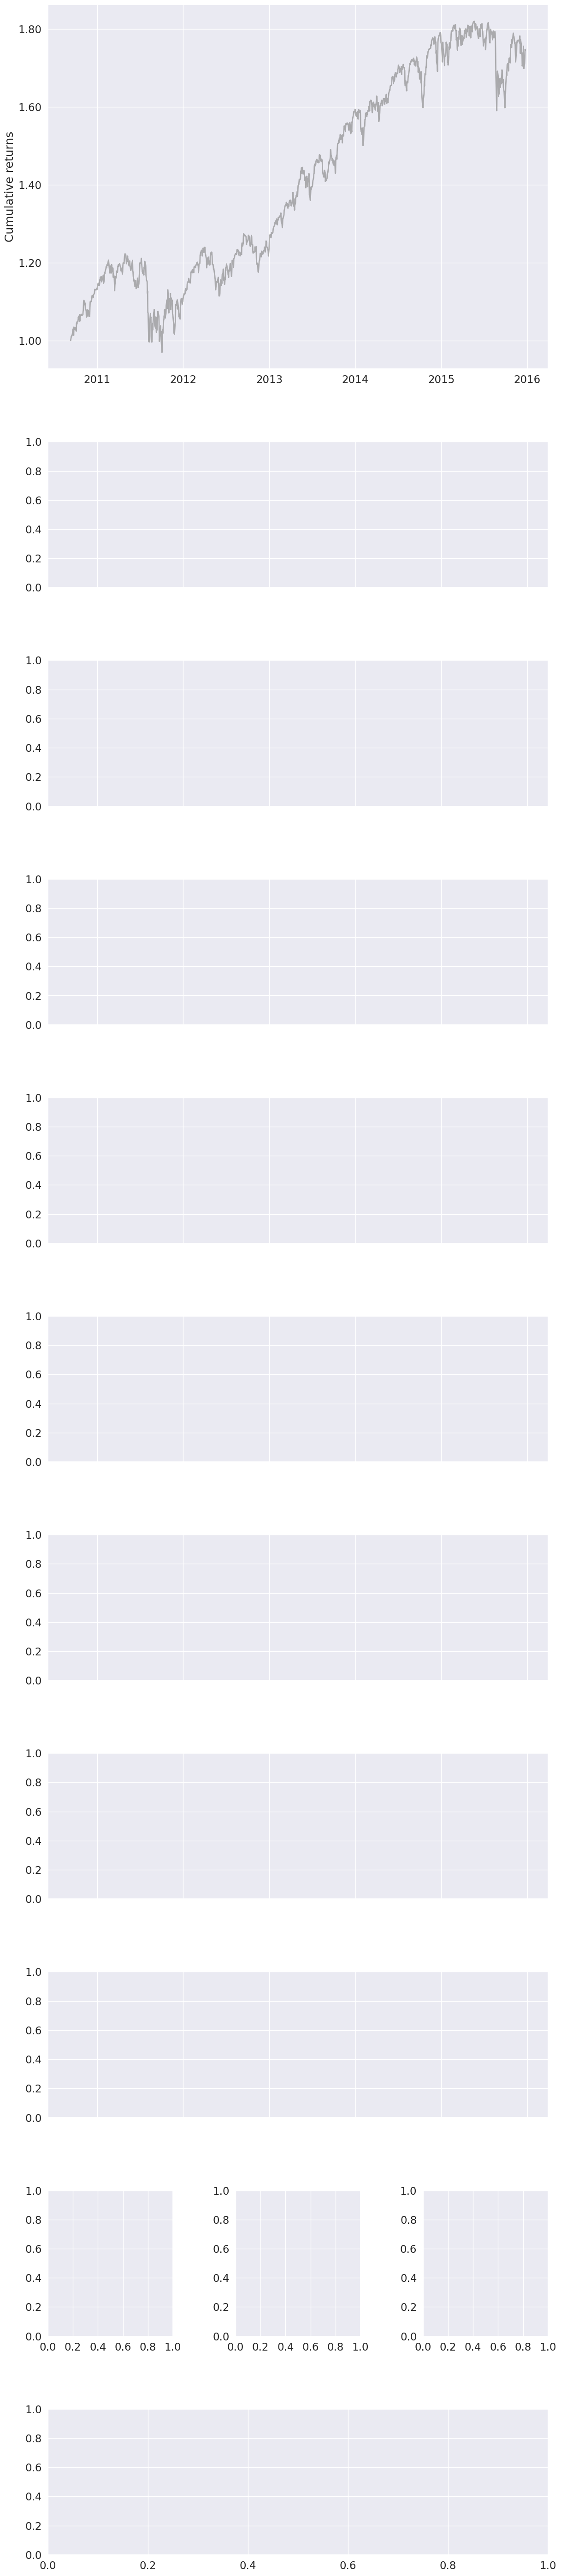

In [212]:
py.create_full_tear_sheet(stock_data['Portfolio_Value_rets'], benchmark_rets = benchmark_data['benchmark_rets'], live_start_date = live_date)

In [ ]:
# Calculate log returns
log_returns = np.log(stock_data / stock_data.shift(1))
log_returns = log_returns.dropna()

In [ ]:
import scipy.stats as stats
import seaborn as sns 
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, axes = plt.subplots(nrows=len(stock_data), ncols=2, figsize=(14, 3*len(stock_data)))

# Iterate over each stock to plot histogram and Q-Q plot
for i, stock in enumerate(stock_data):
    # Histogram
    sns.histplot(log_returns[stock], bins=100, kde=True, ax=axes[i, 0], color='gray')
    axes[i, 0].set_title(f'Histogram of {stock} Log Returns')
    axes[i, 0].set_xlabel('Log Return')
    axes[i, 0].set_ylabel('Frequency')
    
    # Q-Q plot
    stats.probplot(log_returns[stock], dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f'Q-Q Plot of {stock} Log Returns')

plt.tight_layout()
plt.show()



ValueError: Image size of 1400x527400 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function _draw_all_if_interactive at 0x1245faef0> (for post_execute):


ValueError: Image size of 1400x527400 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1400x527400 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1400x527400 with 3516 Axes>

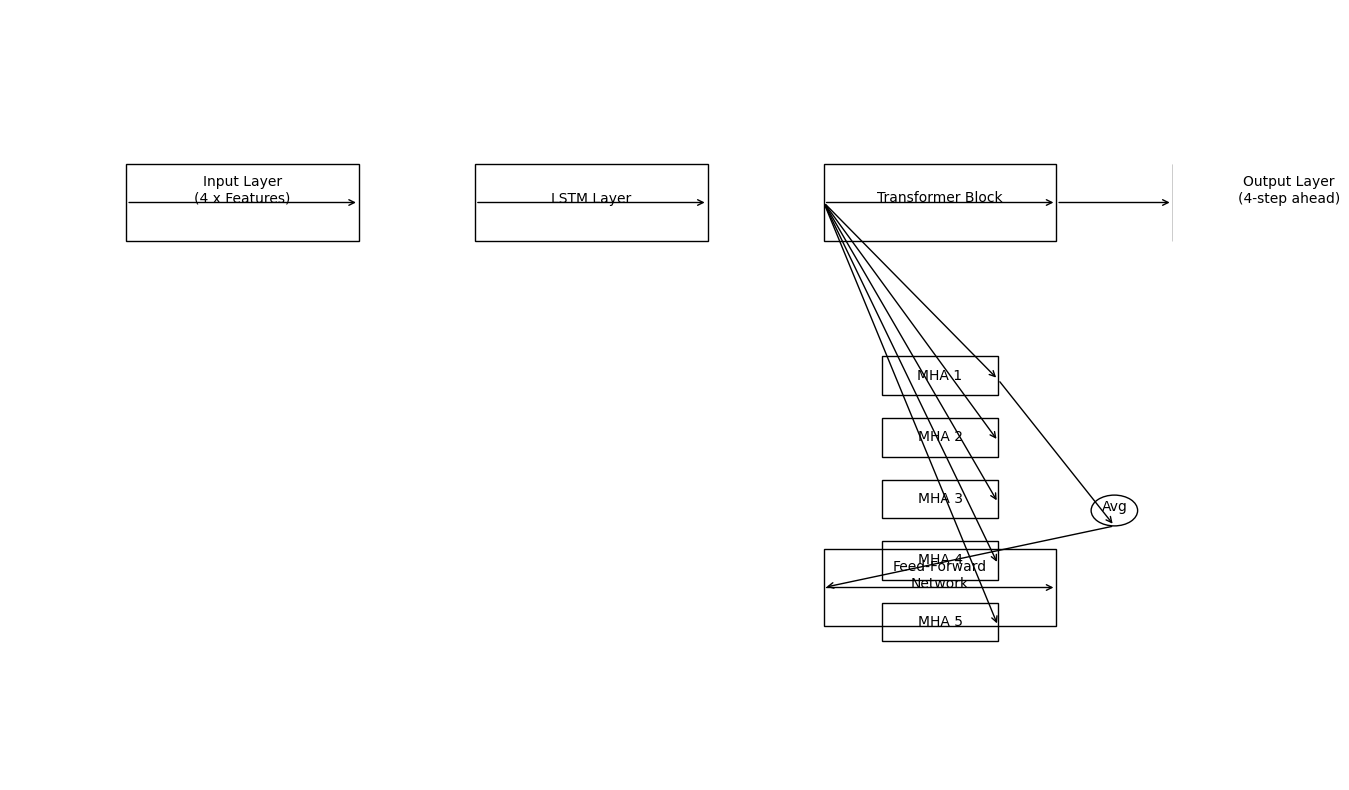

In [1]:
# Importing necessary libraries for sketching the architecture diagram
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Initialize the figure
fig, ax = plt.subplots(figsize=(15, 10))

# Draw rectangles to represent layers and operations
# Input Layer
ax.add_patch(patches.Rectangle((0.1, 0.7), 0.2, 0.1, edgecolor='black', facecolor='none'))
plt.text(0.2, 0.75, 'Input Layer\n(4 x Features)', horizontalalignment='center')

# LSTM Layer
ax.add_patch(patches.Rectangle((0.4, 0.7), 0.2, 0.1, edgecolor='black', facecolor='none'))
plt.text(0.5, 0.75, 'LSTM Layer', horizontalalignment='center')

# Transformer Block
ax.add_patch(patches.Rectangle((0.7, 0.7), 0.2, 0.1, edgecolor='black', facecolor='none'))
plt.text(0.8, 0.75, 'Transformer Block', horizontalalignment='center')

# Bagging Multi-Head Attentions inside Transformer Block
for i in range(5):
    ax.add_patch(patches.Rectangle((0.75, 0.5 - i * 0.08), 0.1, 0.05, edgecolor='black', facecolor='none'))
    plt.text(0.8, 0.52 - i * 0.08, f'MHA {i+1}', horizontalalignment='center')

# Averaging Node for Bagging
ax.add_patch(patches.Circle((0.95, 0.35), 0.02, edgecolor='black', facecolor='none'))
plt.text(0.95, 0.35, 'Avg', horizontalalignment='center')

# Feed-Forward Network inside Transformer Block
ax.add_patch(patches.Rectangle((0.7, 0.2), 0.2, 0.1, edgecolor='black', facecolor='none'))
plt.text(0.8, 0.25, 'Feed-Forward\nNetwork', horizontalalignment='center')

# Output Layer
ax.add_patch(patches.Rectangle((1, 0.7), 0.2, 0.1, edgecolor='black', facecolor='none'))
plt.text(1.1, 0.75, 'Output Layer\n(4-step ahead)', horizontalalignment='center')

# Arrows to indicate flow
arrowprops = dict(facecolor='black', edgecolor='black', arrowstyle='->')
plt.annotate('', xy=(0.3, 0.75), xytext=(0.1, 0.75), arrowprops=arrowprops)
plt.annotate('', xy=(0.6, 0.75), xytext=(0.4, 0.75), arrowprops=arrowprops)
plt.annotate('', xy=(0.9, 0.75), xytext=(0.7, 0.75), arrowprops=arrowprops)
plt.annotate('', xy=(1.0, 0.75), xytext=(0.9, 0.75), arrowprops=arrowprops)
plt.annotate('', xy=(1.2, 0.75), xytext=(1.0, 0.75), arrowprops=arrowprops)
for i in range(5):
    plt.annotate('', xy=(0.85, 0.52 - i * 0.08), xytext=(0.7, 0.75), arrowprops=arrowprops)
plt.annotate('', xy=(0.95, 0.33), xytext=(0.85, 0.52), arrowprops=arrowprops)
plt.annotate('', xy=(0.7, 0.25), xytext=(0.95, 0.33), arrowprops=arrowprops)
plt.annotate('', xy=(0.9, 0.25), xytext=(0.7, 0.25), arrowprops=arrowprops)

# Hide axes
ax.axis('off')

plt.show()
